## Data Loading and Preprocessing

To begin, we load the data into a Pandas data frame from a csv file.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/data.csv') # read in the csv file

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a cursory glance at the data to see what we're working with.

In [3]:
df.head()

,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,...,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season
0,36,2015-09-10,2015091000,1,1,NaN,15:00,15.0,3600.0,0.0,...,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
1,51,2015-09-10,2015091000,1,1,1.0,15:00,15.0,3600.0,0.0,...,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
2,72,2015-09-10,2015091000,1,1,1.0,14:21,15.0,3561.0,39.0,...,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
3,101,2015-09-10,2015091000,1,1,2.0,14:04,15.0,3544.0,17.0,...,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
4,122,2015-09-10,2015091000,1,1,1.0,13:26,14.0,3506.0,38.0,...,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015


There's a lot of data that we don't care about. For example, 'PassAttempt' is a binary attribute, but there's also an attribute called 'PlayType' which is set to 'Pass' for a passing play.

We define a list of the columns which we're not interested in, and then we delete them

In [4]:
columns_to_delete = ['Unnamed: 0', 'Date', 'time', 'TimeUnder', 
                     'PosTeamScore', 'PassAttempt', 'RushAttempt', 
                     'DefTeamScore', 'Season', 'PlayAttempted']

#Iterate through and delete the columns we don't want
for col in columns_to_delete:
    if col in df:
        del df[col]

We can then grab a list of the remaining column names

In [5]:
df.columns

Index(['GameID', 'Drive', 'qtr', 'down', 'TimeSecs', 'PlayTimeDiff',
       'SideofField', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo',
       'FirstDown', 'posteam', 'DefensiveTeam', 'desc', 'Yards.Gained', 'sp',
       'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'Safety',
       'PlayType', 'Passer', 'PassOutcome', 'PassLength', 'PassLocation',
       'InterceptionThrown', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap',
       'Receiver', 'Reception', 'ReturnResult', 'Returner', 'Tackler1',
       'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'Fumble',
       'RecFumbTeam', 'RecFumbPlayer', 'Sack', 'Challenge.Replay',
       'ChalReplayResult', 'Accepted.Penalty', 'PenalizedTeam', 'PenaltyType',
       'PenalizedPlayer', 'Penalty.Yards', 'ScoreDiff', 'AbsScoreDiff'],
      dtype='object')

Temporary simple data replacement so that we can cast to integers (instead of objects)

In [6]:
df = df.replace(to_replace=np.nan,value=-1)

At this point, lots of things are encoded as objects, or with excesively large data types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46129 entries, 0 to 46128
Data columns (total 54 columns):
GameID                46129 non-null int64
Drive                 46129 non-null int64
qtr                   46129 non-null int64
down                  46129 non-null float64
TimeSecs              46129 non-null float64
PlayTimeDiff          46129 non-null float64
SideofField           46129 non-null object
yrdln                 46129 non-null float64
yrdline100            46129 non-null float64
ydstogo               46129 non-null int64
ydsnet                46129 non-null int64
GoalToGo              46129 non-null float64
FirstDown             46129 non-null float64
posteam               46129 non-null object
DefensiveTeam         46129 non-null object
desc                  46129 non-null object
Yards.Gained          46129 non-null int64
sp                    46129 non-null int64
Touchdown             46129 non-null int64
ExPointResult         46129 non-null object
TwoPointConv

We define four lists based on the types of features we're using.
Binary features are separated from the other categorical features so that they can be stored in less space

In [8]:
continuous_features = ['TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100',
                       'ydstogo', 'ydsnet', 'Yards.Gained', 'Penalty.Yards',
                       'ScoreDiff', 'AbsScoreDiff']

ordinal_features = ['Drive', 'qtr', 'down']
binary_features = ['GoalToGo', 'FirstDown','sp', 'Touchdown', 'Safety', 'Fumble']
categorical_features = df.columns.difference(continuous_features).difference(ordinal_features)

We then cast all of the columns to the appropriate underlying data types

In [9]:
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[binary_features] = df[binary_features].astype(np.int8)

THIS IS SOME MORE REFORMATTING SHIT I'M DOING FOR NOW. PROLLY GONNA KEEP IT

In [10]:
df['PassOutcome'].replace(['Complete', 'Incomplete Pass'], [1, 0], inplace=True)

Now all of the objects are encoded the way we'd like them to be

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46129 entries, 0 to 46128
Data columns (total 54 columns):
GameID                46129 non-null int64
Drive                 46129 non-null int64
qtr                   46129 non-null int64
down                  46129 non-null int64
TimeSecs              46129 non-null float64
PlayTimeDiff          46129 non-null float64
SideofField           46129 non-null object
yrdln                 46129 non-null float64
yrdline100            46129 non-null float64
ydstogo               46129 non-null float64
ydsnet                46129 non-null float64
GoalToGo              46129 non-null int8
FirstDown             46129 non-null int8
posteam               46129 non-null object
DefensiveTeam         46129 non-null object
desc                  46129 non-null object
Yards.Gained          46129 non-null float64
sp                    46129 non-null int8
Touchdown             46129 non-null int8
ExPointResult         46129 non-null object
TwoPointConv    

Now we can start to take a look at what's in each of our columns

In [12]:
df.describe()

,GameID,Drive,qtr,down,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,...,InterceptionThrown,Reception,FieldGoalDistance,Fumble,Sack,Challenge.Replay,Accepted.Penalty,Penalty.Yards,ScoreDiff,AbsScoreDiff
count,4.612900e+04,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,...,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000
mean,2.015164e+09,12.279607,2.583407,1.534176,1685.747989,20.189750,28.495870,49.293286,7.310152,26.672289,...,0.010145,0.259641,-0.160268,0.013592,0.027401,0.008953,0.076633,0.652388,-1.057578,7.345076
std,2.183164e+05,7.144244,1.134256,1.422973,1065.964474,17.618167,12.657879,24.943136,4.920808,25.379980,...,0.100214,0.438443,5.871452,0.115792,0.163252,0.094198,0.266011,2.716825,10.554045,7.652127
min,2.015091e+09,1.000000,1.000000,-1.000000,-747.000000,-1.000000,-1.000000,-1.000000,0.000000,-48.000000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.000000,-1.000000
25%,2.015101e+09,6.000000,2.000000,1.000000,758.000000,5.000000,20.000000,31.000000,3.000000,5.000000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,1.000000
50%,2.015111e+09,12.000000,3.000000,2.000000,1800.000000,16.000000,30.000000,50.000000,9.000000,20.000000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,2.015121e+09,18.000000,4.000000,3.000000,2579.000000,37.000000,38.000000,71.000000,10.000000,45.000000,...,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,11.000000
max,2.016010e+09,33.000000,5.000000,4.000000,3600.000000,940.000000,50.000000,99.000000,42.000000,99.000000,...,1.000000,1.000000,66.000000,1.000000,1.000000,1.000000,1.000000,55.000000,41.000000,41.000000


In [13]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
#Embed figures in the Jupyter Notebook
%matplotlib inline

#Use GGPlot style for matplotlib
plt.style.use('ggplot')

In [14]:
pass_plays = df[df['PlayType'] == "Pass"]
pass_plays_grouped = pass_plays.groupby(by=['Passer'])

We can take a random sample of passers and show their completion rate:

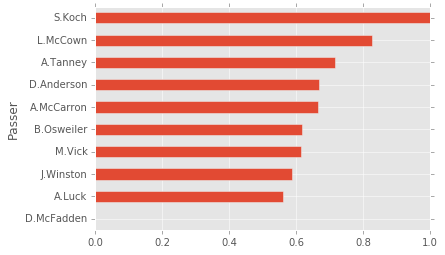

In [15]:
completion_rate = pass_plays_grouped.PassOutcome.sum() / pass_plays_grouped.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can also group by both passer and receiver, to check for highly effective QB-Receiver combos.

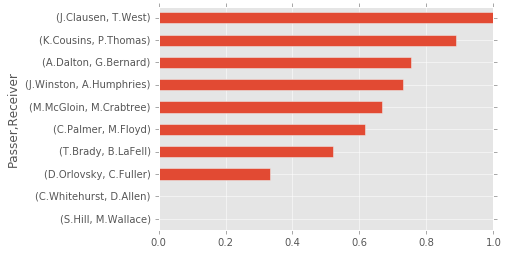

In [16]:
pass_plays_grouped = pass_plays.groupby(by=['Passer', 'Receiver'])
completion_rate = pass_plays_grouped.PassOutcome.sum() / pass_plays_grouped.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can eliminate combos who didn't have at least 10 receptions together, and then re-sample the data. This will remove noise from QB-receiver combos who have very high or low completion rates because they've played very little together.

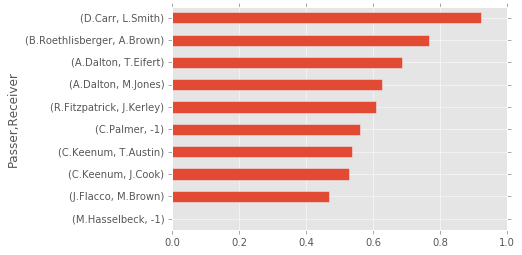

In [17]:
pass_plays_grouped_filtered = pass_plays_grouped.filter(lambda g: len(g)>10).groupby(by=['Passer', 'Receiver'])
completion_rate = pass_plays_grouped_filtered.PassOutcome.sum() / pass_plays_grouped_filtered.PassOutcome.count()
completion_rate_sampled = completion_rate.sample(10)
completion_rate_sampled.sort_values(inplace=True)
completion_rate_sampled.plot(kind='barh')

We can also extract the highest-completion percentage combos.
Here we take the top-10 most reliable QB-receiver pairs.

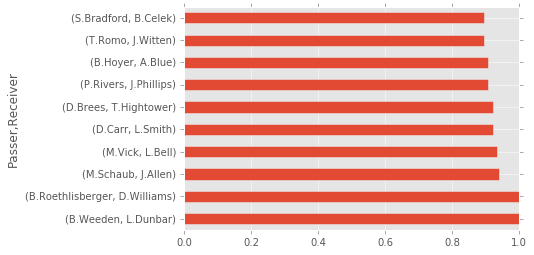

In [18]:
completion_rate.sort_values(inplace=True, ascending = False)
completion_rate = pd.Series(completion_rate)
completion_rate[0:10].plot(kind='barh')

Next, let's find the top ten rushers based on yards-per-carry (only for rushers who have more than 10 carries)

In [20]:
rush_plays = df[(df.Rusher != -1)]
rush_plays_grouped = rush_plays.groupby(by=['Rusher']).filter(lambda g: len(g) > 10).groupby(by=["Rusher"])

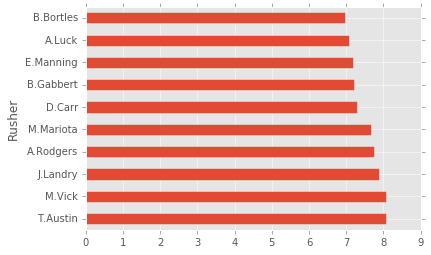

In [21]:
yards_per_carry = rush_plays_grouped["Yards.Gained"].sum() / rush_plays_grouped["Yards.Gained"].count()
yards_per_carry.sort_values(inplace=True, ascending=False)
yards_per_carry[0:10].plot(kind='barh')

Now let's take a look at defenses. Which defenses allowed the fewest overall yards?

In [22]:
def_play_groups = df.groupby("DefensiveTeam")

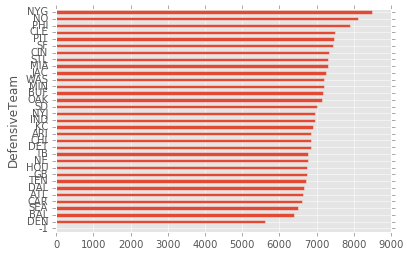

In [24]:
def_yards_allowed = def_play_groups["Yards.Gained"].sum()
def_yards_allowed.sort_values(inplace=True)
def_yards_allowed.plot(kind='barh')

It looks like the Denver Broncos allowed the fewest yards overall. Go Broncos!
Let's see if there were any specific weaknesses in the Broncos' defense.

In [25]:
broncos_def_plays = df[df.DefensiveTeam == "DEN"]
broncos_def_pass_plays = broncos_def_plays[broncos_def_plays.PlayType == "Pass"]
broncos_def_rush_plays = broncos_def_plays[broncos_def_plays.PlayType == "Run"]

print("Passing yards: " + str(broncos_def_pass_plays["Yards.Gained"].sum()))
print("Rushing yards: " + str(broncos_def_rush_plays["Yards.Gained"].sum()))

Passing yards: 3576.0
Rushing yards: 1345.0


It looks like they gave up a lot more passing yards than rushing yards.
Let's see what QBs caused the Denver defense the most trouble.

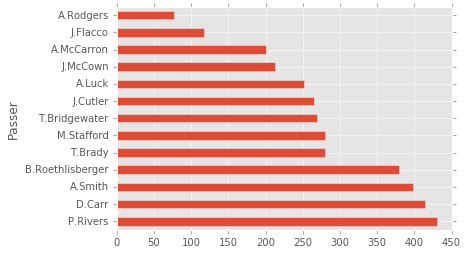

In [27]:
pass_plays = df[df.PlayType == "Pass"]
pass_plays_against_den = pass_plays[pass_plays.DefensiveTeam == "DEN"]
pass_plays_against_den_grouped = pass_plays_against_den.groupby("Passer")
qbs_yards_against_den = pass_plays_against_den_grouped["Yards.Gained"].sum()
qbs_yards_against_den.sort_values(inplace=True, ascending=False)
qbs_yards_against_den.plot(kind='barh')

It looks like the Raiders' Derek Carr caused a lot of trouble.
From this data we can see that when the Broncos play the Raiders, they need to focus more on pass defense.

To figure out which Oakland WR Denver should put their best cornerback on, let's see which Oakland receiver was the highest-performing against Denver.

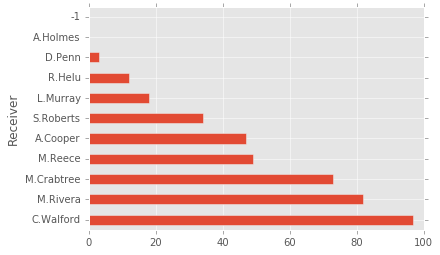

In [29]:
oak_pass_plays_against_den = pass_plays_against_den[pass_plays_against_den.posteam == "OAK"]
oak_pass_plays_against_den_grouped = oak_pass_plays_against_den.groupby("Receiver")
oak_receivers_yards_against_den = oak_pass_plays_against_den_grouped["Yards.Gained"].sum()
oak_receivers_yards_against_den.sort_values(inplace=True, ascending=False)
oak_receivers_yards_against_den.plot(kind='barh')

M. Rivera and M. Crabtree were the dominant receivers. Going in to the game against Oakland this year, we can expext Denver to put their best cornerbacks on them.

But who are their best cornerbacks? We can best judge that by ranking Denver cornerbacks by interception counts.

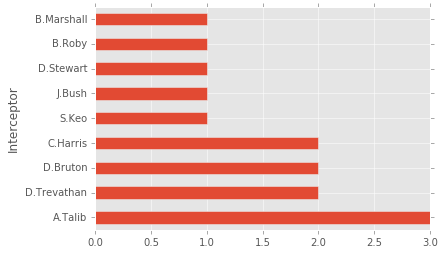

In [31]:
denver_interceptions = pass_plays_against_den[pass_plays_against_den.InterceptionThrown == 1]
denver_interceptions_grouped = denver_interceptions.groupby("Interceptor")
denver_cornerback_interceptions = denver_interceptions_grouped.Interceptor.count()
denver_cornerback_interceptions_sorted = denver_cornerback_interceptions.sort_values(ascending=False)

denver_cornerback_interceptions_sorted.plot(kind='barh')

The Broncos' top choices to cover M. Rivera and M. Crabtree, therefore, are A. Talib and D. Trevathan